In [1]:
# Load GloVe model
GLOVE_PATH = "glove.6B.50d.txt"
EMBEDDING_DIM = 50

def load_word_vectors(path):
    word_vectors = dict()
    f = open(path, encoding="utf-8")
    for line in f:
        values = line.split()
        word = values[0]
        word_numbers = values[1:]
        word_vectors[word] = word_numbers
    f.close()
    print("load {} word vectors.".format(len(word_vectors)))
    return word_vectors

word_vectors = load_word_vectors(GLOVE_PATH)

load 400000 word vectors.


In [101]:
import pandas as pd
import numpy as np

data = pd.read_csv("train.txt/train.csv", encoding="utf-8")
test_data = pd.read_csv("test.txt/test_utf_8.csv", encoding="utf-8")

In [102]:
data = data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")
# data.head(10)

In [103]:
words = list(set(data["Word"].values))
test_words = list(set(test_data["Word"].values))
words.append("ENDPAD")
test_words.append("ENDPAD")

In [104]:
tags = list(set(data["Tag"].values))
test_tags = list(set(test_data["Tag"].values))
# tags

In [105]:
# test_tags

In [106]:
n_words = len(words)
n_tags = len(tags)
print('n_words {}, n_tags {}'.format(n_words,n_tags))

n_words 19069, n_tags 22


In [107]:
# Grouping words into sentence.
# Input : dataframe
# Output : array of sentences.
def group_words(df):
    sentences = []
    sentence = []
    sentence_counter = 1
    sentence_ending_counter = 0
    for index, row in df.iterrows():
        tuple = (row['Word'],row['POS'],row['Tag'])

        sentence.append(tuple)
        if (row['Word'] == '.' and row['POS'] == '.' and row['Tag'] == 'O'):
            sentence_ending_counter += 1
        
        if (sentence_ending_counter > 1):
            sentences.append(sentence)                
            sentence_ending_counter = 0
            sentence = []
                            
    return sentences
    
sentences = group_words(data)
test_sentences = group_words(test_data)
print("# sentences : {}".format(len(sentences)))
print("# test sentences : {}".format(len(test_sentences)))
sentences[0]

# sentences : 8448
# test sentences : 1883


[('Confidence', 'NN', 'B-NP'),
 ('in', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('pound', 'NN', 'I-NP'),
 ('is', 'VBZ', 'B-VP'),
 ('widely', 'RB', 'I-VP'),
 ('expected', 'VBN', 'I-VP'),
 ('to', 'TO', 'I-VP'),
 ('take', 'VB', 'I-VP'),
 ('another', 'DT', 'B-NP'),
 ('sharp', 'JJ', 'I-NP'),
 ('dive', 'NN', 'I-NP'),
 ('if', 'IN', 'B-SBAR'),
 ('trade', 'NN', 'B-NP'),
 ('figures', 'NNS', 'I-NP'),
 ('for', 'IN', 'B-PP'),
 ('September', 'NNP', 'B-NP'),
 (',', ',', 'O'),
 ('due', 'JJ', 'B-ADJP'),
 ('for', 'IN', 'B-PP'),
 ('release', 'NN', 'B-NP'),
 ('tomorrow', 'NN', 'B-NP'),
 (',', ',', 'O'),
 ('fail', 'VB', 'B-VP'),
 ('to', 'TO', 'I-VP'),
 ('show', 'VB', 'I-VP'),
 ('a', 'DT', 'B-NP'),
 ('substantial', 'JJ', 'I-NP'),
 ('improvement', 'NN', 'I-NP'),
 ('from', 'IN', 'B-PP'),
 ('July', 'NNP', 'B-NP'),
 ('and', 'CC', 'I-NP'),
 ('August', 'NNP', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('near-record', 'JJ', 'I-NP'),
 ('deficits', 'NNS', 'I-NP'),
 ('.', '.', 'O'),
 ('.', '.', 'O')]

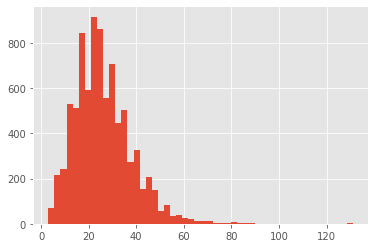

In [108]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [109]:
max_len = 50
word2idx = {w: i for i, w in enumerate(words)}
test_word2idx = {w: i for i, w in enumerate(test_words)}
tag2idx = {t: i for i, t in enumerate(tags)}
test_tag2idx = {t: i for i, t in enumerate(test_tags)}
# word2idx.items()

In [71]:
word2idx["Confidence"]
# test_word2idx["Confidence"]

17124

In [72]:
tag2idx["B-NP"]
test_tag2idx["B-NP"]

5

In [110]:
def create_embedding_matrix(word_index):
    vocabulary_size = len(word_index)
    embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
    for word,i in word_index.items():
        try:
            # print('word[{}] => {}'.format(i,word))
            embedding_vector = word_vectors[word]
            embedding_matrix[i] = np.array(embedding_vector)
        except KeyError:
            vec = np.zeros(EMBEDDING_DIM)
            embedding_matrix[i] = vec
    return embedding_matrix

embedding_matrix = create_embedding_matrix(word2idx)
# embedding_matrix
X[0]

array([17124, 12240, 11067, 11862, 13395,  8975,  4858, 12384,  6456,
       15094, 15422,  8933, 18427,  1244,  1162, 13687,  2914, 14819,
        5200, 13687,  6486,  5324, 14819, 17665, 12384, 10780, 12399,
        4133,  7185, 18387, 15108, 12221,  8346,  4893,  4160, 12575,
        7279,  7279, 19068, 19068, 19068, 19068, 19068, 19068, 19068,
       19068, 19068, 19068, 19068, 19068], dtype=int32)

In [75]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]
X_test = [[test_word2idx[w[0]] for w in s] for s in test_sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)
X_test = pad_sequences(maxlen=max_len, sequences=X_test, padding="post", value=n_words - 1)

In [98]:
X[1]

array([ 5310, 18346, 11067, 17983, 10909, 15075,  4893,   446, 18834,
       12384, 12399,  2739,  6271, 13843, 11021, 15610, 12384, 11328,
       12399,  9496, 12240,   638,  2476, 11067,  1241,  8366,  7279,
        7279, 19068, 19068, 19068, 19068, 19068, 19068, 19068, 19068,
       19068, 19068, 19068, 19068, 19068, 19068, 19068, 19068, 19068,
       19068, 19068, 19068, 19068, 19068], dtype=int32)

In [77]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y_test = [[test_tag2idx[w[2]] for w in s] for s in test_sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
y_test = pad_sequences(maxlen=max_len, sequences=y_test, padding="post", value=tag2idx["O"])

In [78]:
y_test

array([[ 5,  0,  0, ..., 16, 16, 16],
       [ 5, 10,  5, ..., 16, 16, 16],
       [ 5, 10, 13, ..., 16, 16, 16],
       ...,
       [13,  2, 10, ..., 16, 16, 16],
       [13,  5,  4, ..., 16, 16, 16],
       [13,  2,  5, ..., 16, 16, 16]], dtype=int32)

In [79]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [80]:
from sklearn.model_selection import train_test_split
X_training, X_validation, y_training, y_validation = train_test_split(X, y, test_size=0.1)

In [81]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Conv1D, MaxPooling1D,Flatten

In [82]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=EMBEDDING_DIM, input_length=max_len, weights=[embedding_matrix])(input)  # 50-dim embedding
model = Conv1D(128, 5, activation='relu', padding="same")(model) # padding = same so that conv-result doesn't change. (why?)
# model = MaxPooling1D(5)(model)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.1))(model)  # variational biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

In [83]:
model = Model(input, out)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 50)            953450    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 128)           32128     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 256)           263168    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 22)            5654      
Total params: 1,254,400
Trainable params: 1,254,400
Non-trainable params: 0
_________________________________________________

In [84]:
history = model.fit(X_training, np.array(y_training), batch_size=32, epochs=3, validation_split=0.1, verbose=1)

Epoch 1/3
214/214 [==============================] - 34s 143ms/step - loss: 0.7853 - accuracy: 0.7694 - val_loss: 0.2567 - val_accuracy: 0.9221
Epoch 2/3
214/214 [==============================] - 30s 140ms/step - loss: 0.2343 - accuracy: 0.9297 - val_loss: 0.1732 - val_accuracy: 0.9484
Epoch 3/3
214/214 [==============================] - 30s 141ms/step - loss: 0.1612 - accuracy: 0.9513 - val_loss: 0.1430 - val_accuracy: 0.9567


In [93]:
X_test

array([[ 5114,   808,  4820, ..., 19068, 19068, 19068],
       [ 6770,  2408,  4671, ..., 19068, 19068, 19068],
       [ 7804,  4568,  6278, ..., 19068, 19068, 19068],
       ...,
       [ 3066,  3434,  4295, ..., 19068, 19068, 19068],
       [ 3066,  3527,  4977, ..., 19068, 19068, 19068],
       [ 3066,  3081,  2281, ..., 19068, 19068, 19068]], dtype=int32)

In [90]:
train_loss,train_accuracy = model.evaluate(X_training, np.array(y_training), verbose=False)
print("training accuracy: {:.4f}".format(train_accuracy))

training accuracy: 0.9623


In [91]:
valid_loss,valid_accuracy = model.evaluate(X_validation, np.array(y_validation), verbose=False)
print("validation accuracy: {:.4f}".format(valid_accuracy))

validation accuracy: 0.9551


In [ ]:
history = model.fit(X_training, y_training, epochs=3, verbose=1, validation_data=[X_validation,y_validation])

In [94]:
y_test = [to_categorical(i, num_classes=n_tags) for i in y_test]

In [95]:
test_loss,test_accuracy = model.evaluate(X_test, np.array(y_test), verbose=False)
print("test accuracy: {:.4f}".format(test_accuracy))

test accuracy: 0.5843
